In [1]:
import numpy as np
import matplotlib.pyplot as plt
import math
import pandas as pd
from scipy import signal
import pickle
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVR
import random
import tensorflow as tf
import cv2
from scipy import stats
import os


In [2]:
# Add tensorboard stuff
# %load_ext tensorboard
# import datetime

# !rm -rf ./logs/


In [3]:
#fix all seeds for random number generators
# Set seed value
seed_value = 9
import os
os.environ['PYTHONHASHSEED']=str(seed_value)# 2. Set `python` built-in pseudo-random generator at a fixed value
random.seed(seed_value)# 3. Set `numpy` pseudo-random generator at a fixed value
np.random.seed(seed_value)
tf.random.set_seed(seed_value)# 5. Configure a new global `tensorflow` session

# TODO need to add session thing for tensorflow

# Read Depth Camera

In [4]:
# For reading depth camera
def read_depth_camera(dcamera_path, show_video, nw_resize=1, nh_resize=1):
    video  = cv2.VideoCapture(dcamera_path)
    ret, frame = video.read()
    
    # Get total # of frame count 
    frame_count = int(video.get(cv2.CAP_PROP_FRAME_COUNT))
        
    frame_height = int(frame.shape[0])
    frame_width = int(frame.shape[1])

    
    depth_frames = np.empty((frame_count, int(frame_height/nh_resize), int(frame_width/nw_resize)))
    depth_frames = np.empty((frame_count, int(frame_height/nh_resize), int(frame_width/nw_resize),3))
    count = 0
    while (video.isOpened()):
        ret, frame = video.read()
        
        if ret == True:
#             gray_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
#             gray_frame = frame/np.maximum(np.max(frame),255) keep as int8 for memory savings
            gray_frame = frame
            gray_frame = cv2.resize(gray_frame, \
                                    (int(frame_width/nw_resize), int(frame_height/nh_resize)),\
                                    interpolation = cv2.INTER_NEAREST)

            depth_frames[count] = gray_frame
            if show_video == True:
                cv2.imshow("Depth", gray_frame)
                if cv2.waitKey(1) & 0xFF == ord('q'):
                    break
            count = count + 1
        else: 
            break
            

    video.release()
    #cv2.destroyAllWindows()
    return depth_frames

def read_output_data(qtm_file_data, theta):
    if theta=='x':
        qtm_data = pd.read_csv(qtm_file_data, usecols = ["Lean Left/Right Angle (deg)"])
    if theta=='y':
        qtm_data = pd.read_csv(qtm_file_data, usecols = ["Lean Forward/Backwards Angle (deg)"])
    if theta=='z':
        qtm_data = pd.read_csv(qtm_file_data, usecols = ["Torso Twist Angle (deg)"])
        
    
    return qtm_data


In [5]:
def play_video(read_frames):

    for i in range(len(read_frames)):
        # Capture frame-by-frame
        frame = read_frames[i]

        # Display the resulting frame
        plt.imshow(frame)
#         if cv2.waitKey(1) & 0xFF == ord('q'):
#             break
    #cv2.destroyAllWindows()

    return

In [6]:
def show_frame(read_frames, frame_range):
      # Capture frame-by-frame

    # Display the resulting frame
    for i in frame_range:
        fig = plt.figure(figsize=(6,6))        
        a = plt.imshow(read_frames[i])
        
    return

In [7]:
#fix this to concatenate everything
# n_test = 24
# date = '11_15_2020'
# test_str = '/test' + str(n_test)
# #data_dir = r"C:\Users\77bis\Box\CS598 - Final Project\Preliminary Data V4\Test_Subject_Leo" + test_str
# data_dir = "/home/asilador/CS598/CS598-FinalProject/Preliminary Data V4/Test_Subject_Leo" + test_str
# train_dcamera_path = data_dir + '/depth_processed_leo_test'+str(n_test)+'.avi'
# show_video = 0
# n_resize = 1
# x_train = read_depth_camera(train_dcamera_path, show_video, nw_resize=2, nh_resize=3)

n_test = (1,2,24,30,31,32,33,35,1,3)
nw_resize = 2
nh_resize = 2
xtemp = {}
show_video = 0
subj = ['cz','cz','leo','leo','leo','leo','leo','leo','yc','yc']
        
for i in range(len(n_test)):
    test_str = 'test' + str(n_test[i])
    
    data_dir = os.path.join('/home/asilador/CS598/CS598-FinalProject/Preliminary Data V5','Test_Subject_'+subj[i],test_str)
#     data_dir = os.path.join(r'C:\Users\Alex\Box\CS598 - Final Project\Preliminary Data V5','Test_Subject_'+subj[i],test_str)
#     train_dcamera_path = data_dir + '/depth_processed_leo_test'+str(n_test[i])+'.avi'
    train_dcamera_path = os.path.join(data_dir , 'depth_processed_'+subj[i]+'_test'+str(n_test[i])+'.avi')
    xtemp[i] = read_depth_camera(train_dcamera_path, show_video, nw_resize=nw_resize, nh_resize=nh_resize).astype('uint8')
    


In [8]:
tlen=0
for x in range(len(xtemp)):
    tlen+= xtemp[x].shape[0]
xrun_cum = 0
x_train = np.zeros((tlen,xtemp[0].shape[1],xtemp[0].shape[2],xtemp[0].shape[3]),dtype='uint8')
for i in range (len(xtemp)):
    xrun_n = len(xtemp[i])
    x_train[xrun_cum:xrun_cum+xrun_n,:,:,:] = xtemp[i][:xrun_n,:,:,:]
    xrun_cum += xrun_n

In [9]:
x_train.shape

(153421, 60, 80, 3)

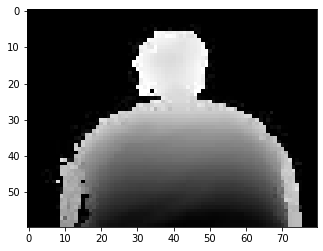

In [10]:
plt.imshow(x_train[153418])

In [11]:
print(x_train.shape)
del xtemp

(153421, 60, 80, 3)


# read fcss data

In [12]:

n_test = (1,2,24,30,31,32,33,35,1,3)
date = ('12_2_2020','12_11_2020','11_15_2020','11_24_2020','11_24_2020','11_25_2020','11_25_2020','11_25_2020','12_2_2020','12_11_2020')
subj = ['cz','cz','leo','leo','leo','leo','leo','leo','yc','yc']
subjwgt = [61,61, 67, 67, 67, 67, 67, 67, 70, 70]
subjht = [180, 180, 174, 174, 174, 174, 174, 174, 170, 170]
xfcss_gt = {}
yrun = 0
for i in range(len(n_test)):
    test_str = 'test' + str(n_test[i])
    data_dir = os.path.join('/home/asilador/CS598/CS598-FinalProject/Preliminary Data V5','Test_Subject_'+subj[i],test_str)
    fcss_data_dir = os.path.join(data_dir , 'fcss_processed_'+subj[i]+'_' + test_str + '_' + date[i] + '.txt')
    xfcss_gttemp = pd.read_csv(fcss_data_dir)
    xfcss_gt[i]=xfcss_gttemp
    xfcss_gt[i]['weight'] = subjwgt[i]# hacky but will work for now
    xfcss_gt[i]['height'] = subjht[i]# hacky but will work for now
    if i==0:
        xfcss_train=xfcss_gttemp
    else:
        xfcss_train = pd.concat([xfcss_train,xfcss_gt[i]],axis=0)
del xfcss_gt

In [13]:
xfcss_train

,Fz bottom (kg),Fz left (kg),Fz right (kg),Fx left (kg),Fx right (kg),Fy (kg),weight,height
0,-50.52,-11.53,-12.09,9.16,11.96,0.24,61,180
1,-50.32,-11.58,-12.22,9.16,11.89,0.19,61,180
2,-50.18,-11.66,-12.37,9.14,11.85,0.16,61,180
3,-50.09,-11.76,-12.48,9.15,11.89,0.14,61,180
4,-50.09,-11.84,-12.59,9.14,11.99,0.14,61,180
...,...,...,...,...,...,...,...,...
23050,-49.75,-19.08,-17.40,11.51,12.78,0.41,70,170
23051,-49.78,-18.89,-17.38,11.59,12.51,0.49,70,170
23052,-49.75,-18.64,-17.39,11.63,12.18,0.54,70,170
23053,-49.72,-18.41,-17.42,11.70,11.89,0.56,70,170


# Read Output Data


In [14]:

n_test = (1,2,24,30,31,32,33,35,1,3)
date = ('12_2_2020','12_11_2020','11_15_2020','11_24_2020','11_24_2020','11_25_2020','11_25_2020','11_25_2020','12_2_2020','12_11_2020')
subj = ['cz','cz','leo','leo','leo','leo','leo','leo','yc','yc']
y_gt = {}
yrun = 0
theta_interest = 'z'
for i in range(len(n_test)):
    test_str = 'test' + str(n_test[i])
    data_dir = os.path.join('/home/asilador/CS598/CS598-FinalProject/Preliminary Data V5','Test_Subject_'+subj[i],test_str)
    qtm_file_data_dir = os.path.join(data_dir , 'qtm_processed_'+subj[i]+'_test' + str(n_test[i]) + '_' + date[i] + '.txt')
    y_gt[i] = read_output_data(qtm_file_data_dir,theta_interest).values

    

# tlen = len(y_gt[0])+len(y_gt[1])+len(y_gt[2])+len(y_gt[3])+len(y_gt[4])+len(y_gt[5])
# y_train = np.zeros((tlen,1))
# xrun = len(y_gt[0])
# y_train[:xrun] = y_gt[0][:xrun]
# xrun1 = xrun + len(y_gt[1])
# y_train[xrun:xrun1]=y_gt[1][:xrun1-xrun]
# xrun2 = xrun1 + len(y_gt[2])
# y_train[xrun1:xrun2] = y_gt[2][:xrun2-xrun1]
# xrun3 = xrun2 + len(y_gt[3])
# y_train[xrun2:xrun3] = y_gt[3][:xrun3-xrun2]
# xrun4 = xrun3 + len(y_gt[4])
# y_train[xrun3:xrun4] = y_gt[4][:xrun4-xrun3]
# xrun5 = xrun4 + len(y_gt[5])
# y_train[xrun4:xrun5] = y_gt[5][:xrun5-xrun4]
# del y_gt

In [15]:
tlen=0
for x in range(len(y_gt)):
    tlen+= y_gt[x].shape[0]
yrun_cum = 0
y_train = np.zeros((tlen,1))
for i in range (len(y_gt)):
    yrun_n = len(y_gt[i])
    y_train[yrun_cum:yrun_cum+yrun_n] = y_gt[i][:]
    yrun_cum += yrun_n

In [16]:
## Saturate output
def saturate(theta, min_val, max_val):
    for i in range(len(theta)):
        if theta[i] < min_val:
            theta[i] = min_val
            continue
        if theta[i] > max_val:
            theta[i] = max_val
            continue
    return theta
            
min_val = -50
max_val = 50
    
y_train = saturate(y_train, min_val, max_val)

In [17]:
print(x_train.shape)
print(xfcss_train.shape)
print(y_train.shape)

(153421, 60, 80, 3)
(153421, 8)
(153421, 1)


In [18]:
nsamps = x_train.shape[0]
n80p = int(np.floor(nsamps*0.8))
rannums = np.array(random.sample(range(1,nsamps,1), n80p))
s_nfiles = np.arange(nsamps)
test_set = np.setdiff1d(s_nfiles,rannums)

#

In [33]:
Trainset = x_train[rannums,:]
Trainset2 = xfcss_train.values[rannums,:]
Testset = x_train[test_set,:]
Testset2 = xfcss_train.values[test_set,:]
# Trainy= y_gt[rannums,:]
# Testy = y_gt[test_set,:]
Trainy= y_train[rannums,:]
Testy = y_train[test_set,:]

In [20]:
sc_X2 = StandardScaler()
sc_y = StandardScaler()

In [21]:
Xtrainz = Trainset
Xtrainz2 = Trainset2
ytrainz = Trainy
X = Xtrainz
X2 = sc_X2.fit_transform(Xtrainz2)
y = sc_y.fit_transform(ytrainz)

In [22]:
#make validation data available to model.fit
Xvalid = Testset
Xvalid2 = sc_X2.transform(Testset2)
y_valid = Testy
y_valid = sc_y.transform(y_valid)


In [23]:
# clear up some used variables
del Trainset
del Trainset2
del Testset
del Testset2


# Regress using Neural Network

In [24]:
x_train.shape

(153421, 60, 80, 3)

In [25]:
# Create Neural Netowrk
# model = tf.keras.Sequential()
# model.add(tf.keras.Input(shape=(X.shape[1],)))
# model.add(tf.keras.layers.Dense(200, activation="relu"))
# #model.add(tf.keras.layers.Dropout(0.5))
# model.add(tf.keras.layers.Dense(200, activation="relu"))
# model.add(tf.keras.layers.Dropout(0.5))          
# model.add(tf.keras.layers.Dense(100, activation='linear')) #added extra layer. probably overkill but want good results
# model.add(tf.keras.layers.Dense(1, activation='linear'))
# model.compile(optimizer='adam',
#               loss='mae',
#               metrics=['mse','mae'])
    
# # loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)

# # loss_fn(y_train[:1], predictions).numpy()
from tensorflow.keras.layers import Bidirectional, Conv2D, MaxPooling2D, Input, concatenate, AveragePooling2D
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Dense, Activation, Dropout, Reshape, Permute, Flatten
from tensorflow.keras.models import Model
dropout_rate = 0.2

model_start = Input(shape=(x_train.shape[1],x_train.shape[2],x_train.shape[3]))
model_start2 = Input(shape=(xfcss_train.shape[1],))
model_cnn = model_start
model_perc = model_start2

model_cnn = Conv2D(filters=16, kernel_size=(3, 3),padding='same')(model_cnn)
model_cnn = Activation('relu')(model_cnn)
model_cnn = AveragePooling2D(pool_size=(2, 2))(model_cnn)

model_perc = Dense(100)(model_perc)
model_perc = Activation('relu')(model_perc)

model_cnn = Conv2D(filters=32, kernel_size=(3, 3),padding='same')(model_cnn)
model_cnn = Activation('relu')(model_cnn)
model_cnn = AveragePooling2D(pool_size=(2, 2))(model_cnn)

model_perc = Dense(100)(model_perc)
model_perc = Activation('relu')(model_perc)

model_cnn = Conv2D(filters=64, kernel_size=(3, 3),padding='same')(model_cnn)
model_cnn = Activation('relu')(model_cnn)
model_cnn = AveragePooling2D(pool_size=(2, 2))(model_cnn)

model_cnn = Conv2D(filters=96, kernel_size=(3, 3),padding='same')(model_cnn)
model_cnn = Activation('relu')(model_cnn)
model_cnn = AveragePooling2D(pool_size=(2, 2))(model_cnn)

model_cnn = Flatten()(model_cnn)
# model_perc = Flatten()(model_perc)
# model_cnn = Activation('relu')(model_cnn)

model_cnn = Dense(128)(model_cnn)
model_cnn = Activation('relu')(model_cnn)
# model_cnn = Dropout(dropout_rate)(model_cnn)

model_comb = concatenate([model_cnn,model_perc],axis=-1)

model_comb = Dense(100)(model_comb)
model_comb = Activation('relu')(model_comb)
model_comb = Dropout(dropout_rate)(model_comb)

output = Dense(1)(model_comb)
output = Activation('linear', name='thetaz_out')(output)
model = Model(inputs=[model_start,model_start2],outputs=output)
model.compile(optimizer='adam',
              loss='mae',
              metrics=['mse','mae'])


callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=50,restore_best_weights=True) #Moving to 1000 patience. 


In [26]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 60, 80, 3)]  0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 60, 80, 16)   448         input_1[0][0]                    
__________________________________________________________________________________________________
activation (Activation)         (None, 60, 80, 16)   0           conv2d[0][0]                     
__________________________________________________________________________________________________
average_pooling2d (AveragePooli (None, 30, 40, 16)   0           activation[0][0]                 
______________________________________________________________________________________________

In [27]:
print(tf.__version__)

2.1.2


In [28]:
tf.config.list_physical_devices('GPU') 

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [ ]:
# # create data generator
# def get_generator_cyclic(features1, features2, labels, batch_size=256):
#     while True:
#         for n in range(int(len(features1)/batch_size)):
#             yield [features1[n*batch_size: (n+1)*batch_size]/255., features2[n*batch_size: (n+1)*batch_size], labels[n*batch_size: (n+1)*batch_size]]
#         permuted = np.random.permutation(len(features1))
#         features1 = features1[permuted]
#         features2 = features2[permuted]
#         labels = labels[permuted]


In [ ]:
# x1, x2, y = next(training_generator)
# plt.imshow(x1[0])

In [ ]:
# from tensorflow.keras.preprocessing.image import ImageDataGenerator
# image_data_gen = ImageDataGenerator(rescale=1/255.,height_shift_range=0.2, fill_mode='nearest')

In [29]:
epochs = int(30000)
batch_size = 256
# training_generator = get_generator_cyclic(Xtrainz, Xtrainz2, ytrainz, batch_size=batch_size)
history = model.fit([X/255.,X2], y,batch_size=batch_size, epochs = epochs,callbacks = [callback],validation_data = ([Xvalid/255.,Xvalid2], y_valid),verbose=2)
# history = model.fit_generator(get_generator_cyclic(Xtrainz, Xtrainz2, ytrainz, batch_size=batch_size))


# model.save('depthforcemodel.h5')
#history.save('depthforcehist.h5')

Train on 122736 samples, validate on 30685 samples
Epoch 1/30000
122736/122736 - 16s - loss: 0.5090 - mse: 0.6256 - mae: 0.5090 - val_loss: 0.4703 - val_mse: 0.5258 - val_mae: 0.4703
Epoch 2/30000
122736/122736 - 14s - loss: 0.4247 - mse: 0.4532 - mae: 0.4247 - val_loss: 0.3892 - val_mse: 0.4069 - val_mae: 0.3892
Epoch 3/30000
122736/122736 - 14s - loss: 0.3803 - mse: 0.3797 - mae: 0.3803 - val_loss: 0.3711 - val_mse: 0.3639 - val_mae: 0.3711
Epoch 4/30000
122736/122736 - 14s - loss: 0.3540 - mse: 0.3400 - mae: 0.3540 - val_loss: 0.3334 - val_mse: 0.3233 - val_mae: 0.3334
Epoch 5/30000
122736/122736 - 14s - loss: 0.3352 - mse: 0.3139 - mae: 0.3352 - val_loss: 0.3203 - val_mse: 0.3012 - val_mae: 0.3203
Epoch 6/30000
122736/122736 - 14s - loss: 0.3200 - mse: 0.2930 - mae: 0.3200 - val_loss: 0.3059 - val_mse: 0.2833 - val_mae: 0.3059
Epoch 7/30000
122736/122736 - 14s - loss: 0.3068 - mse: 0.2749 - mae: 0.3068 - val_loss: 0.2942 - val_mse: 0.2677 - val_mae: 0.2942
Epoch 8/30000
122736/1227

Epoch 63/30000
122736/122736 - 14s - loss: 0.1522 - mse: 0.0818 - mae: 0.1522 - val_loss: 0.1666 - val_mse: 0.1064 - val_mae: 0.1666
Epoch 64/30000
122736/122736 - 14s - loss: 0.1514 - mse: 0.0810 - mae: 0.1514 - val_loss: 0.1652 - val_mse: 0.1056 - val_mae: 0.1652
Epoch 65/30000
122736/122736 - 14s - loss: 0.1512 - mse: 0.0808 - mae: 0.1512 - val_loss: 0.1673 - val_mse: 0.1086 - val_mae: 0.1673
Epoch 66/30000
122736/122736 - 14s - loss: 0.1498 - mse: 0.0801 - mae: 0.1498 - val_loss: 0.1674 - val_mse: 0.1065 - val_mae: 0.1674
Epoch 67/30000
122736/122736 - 14s - loss: 0.1491 - mse: 0.0783 - mae: 0.1491 - val_loss: 0.1644 - val_mse: 0.1046 - val_mae: 0.1644
Epoch 68/30000
122736/122736 - 14s - loss: 0.1483 - mse: 0.0783 - mae: 0.1483 - val_loss: 0.1655 - val_mse: 0.1104 - val_mae: 0.1655
Epoch 69/30000
122736/122736 - 14s - loss: 0.1484 - mse: 0.0782 - mae: 0.1484 - val_loss: 0.1647 - val_mse: 0.1029 - val_mae: 0.1647
Epoch 70/30000
122736/122736 - 14s - loss: 0.1477 - mse: 0.0774 - mae

Epoch 125/30000
122736/122736 - 14s - loss: 0.1250 - mse: 0.0589 - mae: 0.1250 - val_loss: 0.1502 - val_mse: 0.0910 - val_mae: 0.1502
Epoch 126/30000
122736/122736 - 14s - loss: 0.1241 - mse: 0.0585 - mae: 0.1241 - val_loss: 0.1480 - val_mse: 0.0886 - val_mae: 0.1480
Epoch 127/30000
122736/122736 - 14s - loss: 0.1229 - mse: 0.0576 - mae: 0.1229 - val_loss: 0.1501 - val_mse: 0.0896 - val_mae: 0.1501
Epoch 128/30000
122736/122736 - 14s - loss: 0.1230 - mse: 0.0577 - mae: 0.1230 - val_loss: 0.1531 - val_mse: 0.0923 - val_mae: 0.1531
Epoch 129/30000
122736/122736 - 14s - loss: 0.1230 - mse: 0.0578 - mae: 0.1230 - val_loss: 0.1519 - val_mse: 0.0899 - val_mae: 0.1519
Epoch 130/30000
122736/122736 - 14s - loss: 0.1226 - mse: 0.0577 - mae: 0.1226 - val_loss: 0.1540 - val_mse: 0.0914 - val_mae: 0.1540
Epoch 131/30000
122736/122736 - 14s - loss: 0.1225 - mse: 0.0575 - mae: 0.1225 - val_loss: 0.1481 - val_mse: 0.0910 - val_mae: 0.1481
Epoch 132/30000
122736/122736 - 14s - loss: 0.1228 - mse: 0.05

Epoch 187/30000
122736/122736 - 14s - loss: 0.1116 - mse: 0.0499 - mae: 0.1116 - val_loss: 0.1432 - val_mse: 0.0877 - val_mae: 0.1432
Epoch 188/30000
122736/122736 - 14s - loss: 0.1120 - mse: 0.0498 - mae: 0.1120 - val_loss: 0.1448 - val_mse: 0.0865 - val_mae: 0.1448
Epoch 189/30000
122736/122736 - 14s - loss: 0.1111 - mse: 0.0495 - mae: 0.1111 - val_loss: 0.1441 - val_mse: 0.0856 - val_mae: 0.1441
Epoch 190/30000
122736/122736 - 14s - loss: 0.1114 - mse: 0.0495 - mae: 0.1114 - val_loss: 0.1442 - val_mse: 0.0871 - val_mae: 0.1442
Epoch 191/30000
122736/122736 - 14s - loss: 0.1118 - mse: 0.0501 - mae: 0.1118 - val_loss: 0.1477 - val_mse: 0.0884 - val_mae: 0.1477
Epoch 192/30000
122736/122736 - 14s - loss: 0.1116 - mse: 0.0497 - mae: 0.1116 - val_loss: 0.1477 - val_mse: 0.0886 - val_mae: 0.1477
Epoch 193/30000
122736/122736 - 14s - loss: 0.1110 - mse: 0.0496 - mae: 0.1110 - val_loss: 0.1445 - val_mse: 0.0852 - val_mae: 0.1445
Epoch 194/30000
122736/122736 - 14s - loss: 0.1104 - mse: 0.04

Epoch 249/30000
122736/122736 - 14s - loss: 0.1042 - mse: 0.0440 - mae: 0.1042 - val_loss: 0.1452 - val_mse: 0.0862 - val_mae: 0.1452
Epoch 250/30000
122736/122736 - 14s - loss: 0.1043 - mse: 0.0442 - mae: 0.1043 - val_loss: 0.1464 - val_mse: 0.0866 - val_mae: 0.1464
Epoch 251/30000
122736/122736 - 14s - loss: 0.1039 - mse: 0.0437 - mae: 0.1039 - val_loss: 0.1453 - val_mse: 0.0872 - val_mae: 0.1453
Epoch 252/30000
122736/122736 - 14s - loss: 0.1042 - mse: 0.0440 - mae: 0.1042 - val_loss: 0.1455 - val_mse: 0.0858 - val_mae: 0.1455
Epoch 253/30000
122736/122736 - 14s - loss: 0.1044 - mse: 0.0441 - mae: 0.1044 - val_loss: 0.1437 - val_mse: 0.0864 - val_mae: 0.1437
Epoch 254/30000
122736/122736 - 14s - loss: 0.1033 - mse: 0.0437 - mae: 0.1033 - val_loss: 0.1419 - val_mse: 0.0838 - val_mae: 0.1419
Epoch 255/30000
122736/122736 - 14s - loss: 0.1032 - mse: 0.0436 - mae: 0.1032 - val_loss: 0.1431 - val_mse: 0.0849 - val_mae: 0.1431
Epoch 256/30000
122736/122736 - 14s - loss: 0.1035 - mse: 0.04

In [ ]:
#%tensorboard --logdir logs/fit

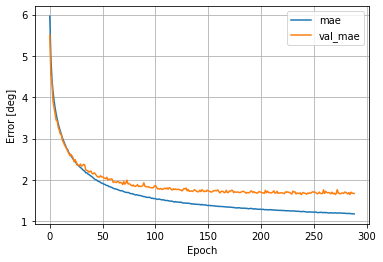

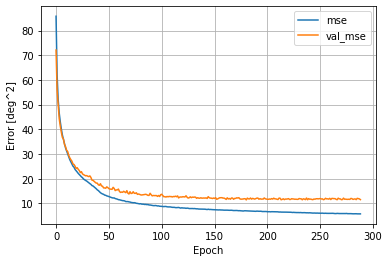

In [31]:
def plot_loss(history):
    
    v1 = history.history['mae']*np.sqrt(sc_y.var_)
    v2 = history.history['val_mae']*np.sqrt(sc_y.var_)
    fig1 = plt.figure()
    ax1 = fig1.add_subplot(111)
    ax1.plot(v1, label='mae')
    ax1.plot(v2, label='val_mae')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Error [deg]')
    ax1.legend()
    ax1.grid(True)
    plt.show()
    
    v3 = history.history['mse']*sc_y.var_
    v4 = history.history['val_mse']*sc_y.var_
    fig2 = plt.figure()
    ax2 = fig2.add_subplot(111)
    ax2.plot(v3, label='mse')
    ax2.plot(v4, label='val_mse')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Error [deg^2]')
    ax2.legend()
    ax2.grid(True)
    plt.show()
    
    
plot_loss(history)


### 4-layer Network: Predict Against Training Data as a Sanity Check

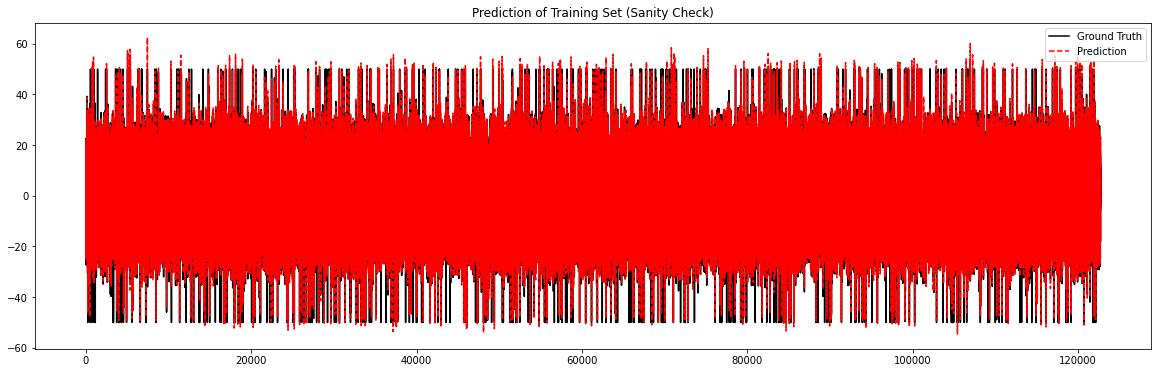

Average error is 0.05 degrees
Root Mean Squared Error is 0.85 degrees
Mean Absolute Error is 0.85 degrees


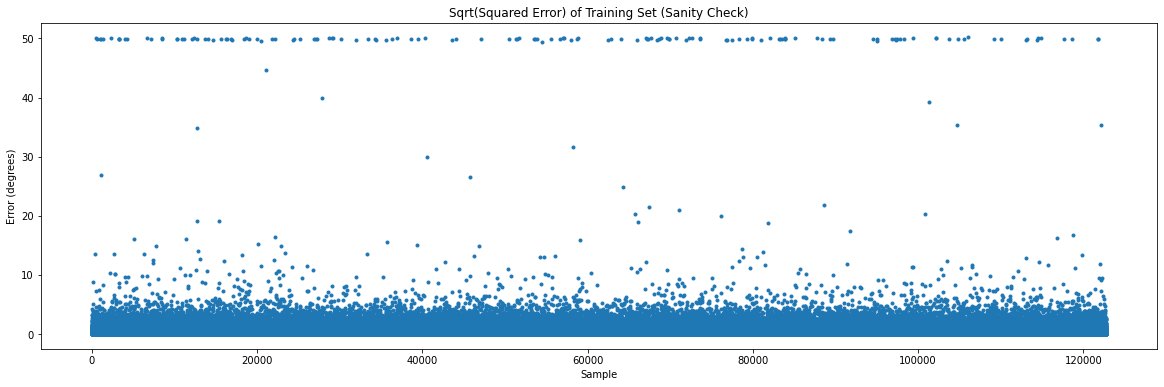

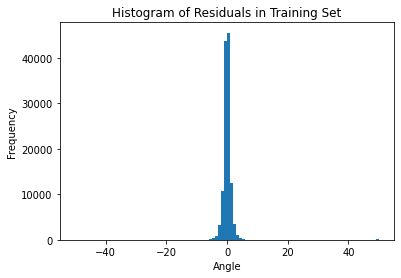

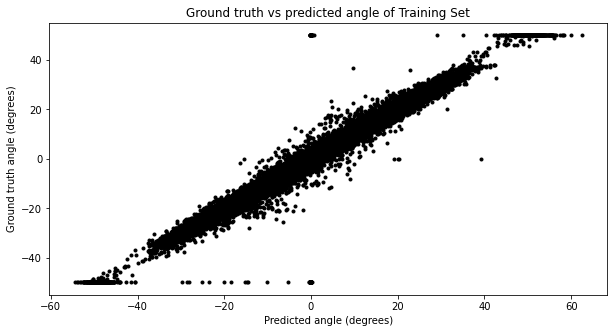

In [34]:

# sanity check with 80% data
Xtrainz = Trainset/255.
Xtrainz2 = sc_X2.transform(Trainset2)
y_pred = model.predict([Xtrainz,Xtrainz2])
#y_pred = sc_y.inverse_transform(y_pred)
y_pred = sc_y.inverse_transform(y_pred)
y_new = Trainy
plt.figure(figsize=(20,6))
plt.plot(y_new,'k')
plt.plot(y_pred,'r--')
plt.title('Prediction of Training Set (Sanity Check)')
#plt.axis([xmin, xmax, ymin, ymax])
plt.legend(labels=['Ground Truth','Prediction'])
plt.show()
# Squared-root of Squared Error

test_error = (y_pred - y_new)
print('Average error is {:4.2f} degrees'.format(np.sum(test_error)/test_error.shape[0]))
rmse = np.sqrt(test_error**2)
print('Root Mean Squared Error is {:4.2f} degrees'.format(np.sum(rmse)/test_error.shape[0]))
# Mean absolute error
print('Mean Absolute Error is {:4.2f} degrees'.format(np.sum(np.abs(test_error))/test_error.shape[0]))
plt.figure(figsize=(20,6))
plt.plot(rmse,'.')
plt.title('Sqrt(Squared Error) of Training Set (Sanity Check)')
plt.xlabel('Sample')
plt.ylabel('Error (degrees)')
plt.show()

plt.figure()
plt.hist(test_error,bins=100)
plt.title('Histogram of Residuals in Training Set')
plt.xlabel('Angle')
plt.ylabel('Frequency')
plt.show()

#plot scatterplot of data
plt.figure(figsize=(10,5))
plt.scatter(y_pred,y_new,marker='.',color='black')
plt.xlabel('Predicted angle (degrees)')
plt.ylabel('Ground truth angle (degrees)')
plt.title('Ground truth vs predicted angle of Training Set')
plt.show()

### 4-layer Neural Network: Predict Test Set

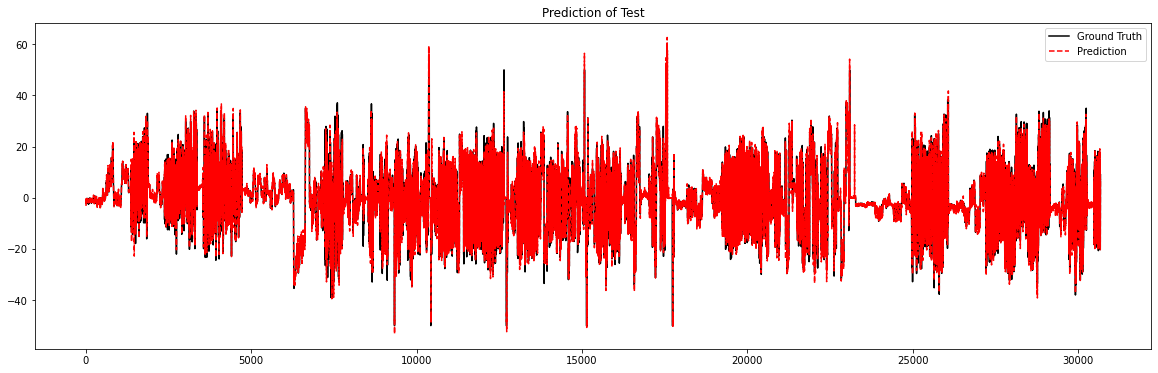

Average error is 0.06 degrees
Root Mean Squared Error is 1.64 degrees
Mean Absolute Error is 1.64 degrees


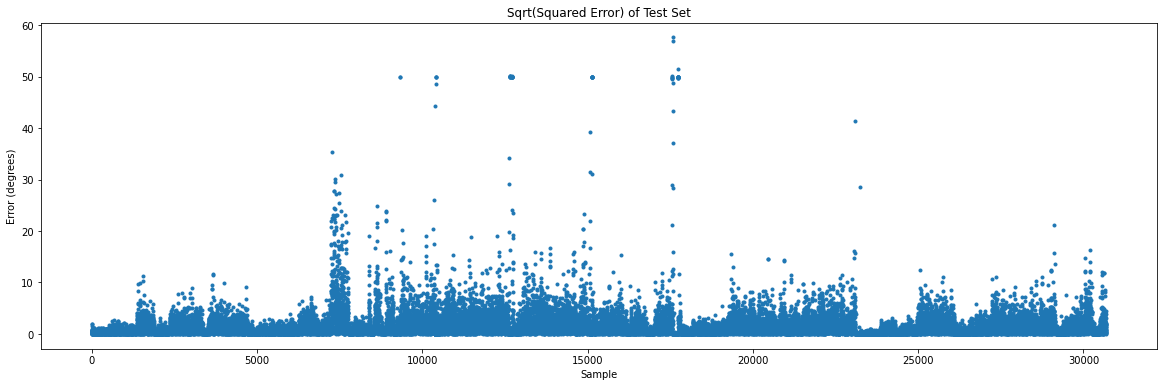

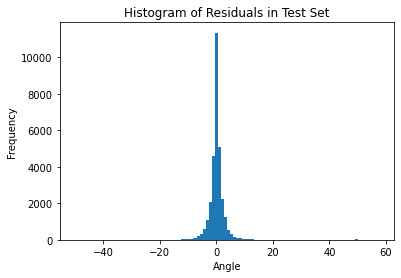

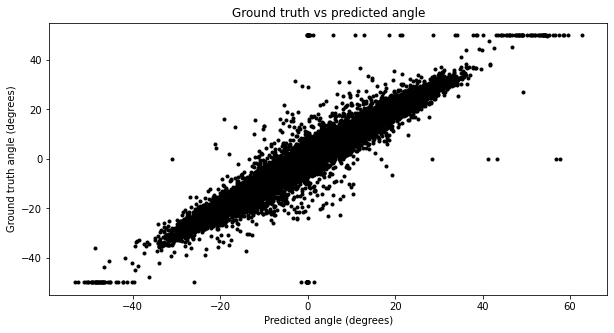

In [35]:
# Redo test set
Xtest = Testset/255.
Xtest2 = sc_X2.transform(Testset2)
y_pred = model.predict([Xtest,Xtest2])
#y_pred = sc_y.inverse_transform(y_pred)
y_pred = sc_y.inverse_transform(y_pred)
y_new = Testy

plt.figure(figsize=(20,6))
plt.plot(y_new,'k')
plt.plot(y_pred,'r--')
plt.title('Prediction of Test')
#plt.axis([xmin, xmax, ymin, ymax])
plt.legend(labels=['Ground Truth','Prediction'])
plt.show()

# Squared-root of Squared Error

test_error = (y_pred - y_new)
print('Average error is {:4.2f} degrees'.format(np.sum(test_error)/test_error.shape[0]))
rmse = np.sqrt(test_error**2)
print('Root Mean Squared Error is {:4.2f} degrees'.format(np.sum(rmse)/test_error.shape[0]))
# Mean absolute error
print('Mean Absolute Error is {:4.2f} degrees'.format(np.sum(np.abs(test_error))/test_error.shape[0]))
plt.figure(figsize=(20,6))
plt.plot(rmse,'.')
plt.title('Sqrt(Squared Error) of Test Set')
plt.xlabel('Sample')
plt.ylabel('Error (degrees)')
plt.show()

plt.figure()
plt.hist(test_error,bins=100)
plt.title('Histogram of Residuals in Test Set')
plt.xlabel('Angle')
plt.ylabel('Frequency')
plt.show()

#plot scatterplot of data
plt.figure(figsize=(10,5))
plt.scatter(y_pred,y_new,marker='.',color='black')
plt.xlabel('Predicted angle (degrees)')
plt.ylabel('Ground truth angle (degrees)')
plt.title('Ground truth vs predicted angle')
plt.show()

In [30]:
save_notebookparams = 1
if save_notebookparams:
    pkl_filename = "depthforcemodelparam_cnn3v20_pb.pkl"
    randata = {}
    randata['nsamps']=nsamps
    randata['n80p']=n80p
    randata['rannums']=rannums
    randata['test_set']=test_set
    modelhistory = history.history
    
    
    with open(pkl_filename, 'wb') as file:
        pickle.dump([randata,sc_y,sc_X2,modelhistory], file)
        
    !mkdir -p saved_model
    model.save('saved_model/cnn3v20')

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
INFO:tensorflow:Assets written to: saved_model/cnn3v20/assets
